# 2d finite Differenzen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from scipy.linalg import cho_factor, cho_solve

Wir betrachten die Poisson-Gleichung
$$-\Delta u(x,y) = f(x,y)\quad (x,y)\in D$$
mit der Randbedingung
$$u(x,y) = g(x,y)\quad (x,y) \in \partial D.$$

Um die Lösung numerisch berechnen zu können, müssen wir die Gleichung diskretisieren. Dazu wenden wir den Differenzen-Quotienten in $x$ und $y$ Richtung für den Laplace Operator an:

$$\Delta u(x,y) = u_{xx}(x,y) + u_{yy}(x,y) \approx \frac{u(x-h,y)-2 u(x,y) + u(x+h,y)}{h^2} + \frac{u(x,y-h)-2 u(x,y) + u(x,y+h)}{h^2}.$$

Damit folgt für die inneren Punkte eines Gebiets

$$\Delta u(x,y) \approx \Delta_h u(x,y) = \frac{u(x-h,y)+u(x,y-h)-4 u(x,y) + u(x+h,y)+u(x,y+h)}{h^2}.$$

Für Randpunkte kann die Differenz nicht berechnet werden: so ist zum Beispiel am linken Rand eines Rechteck Gebiets $(x-h,y)\not\in D$.

Um die Diskretisierung einfach zu halten, betrachten wir ein quadratisches Gebiet $D = [0,1]^2$.

Sei
$$u_{i,j} = u(x_i, y_j),$$
wobei mit
$$x_i = \frac{i}{n},\quad y_j = \frac{j}{n}\quad \text{für}\ i,j = 0,\ldots, n$$
von einer regelmässigen Zerlegung des Einheitsquadrats ausgegangen wird. 

In [3]:
n = 10
h = 1/n
y,x = np.mgrid[0:1:(n+1)*1j,0:1:(n+1)*1j]

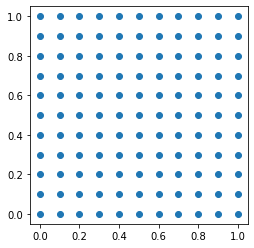

In [4]:
if n == 10:
    plt.scatter(x,y)
    plt.gca().set_aspect(1)
    plt.show()

Betrachten wir den Differenzen-Quotient für den Punkt $(0.4,0.4)$, so sind die Punkte
$$(0.3,0.4), (0.4,0.4), (0.5,0.4), (0.4,0.3), (0.4,0.5)$$
involviert.


In [5]:
pkt = np.array([(0.3,0.4), (0.4,0.4), (0.5,0.4), (0.4,0.3), (0.4,0.5)])

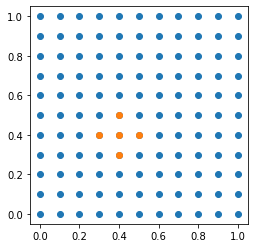

In [6]:
if n == 10:
    plt.scatter(x,y)
    plt.scatter(pkt[:,0],pkt[:,1])
    plt.gca().set_aspect(1)
    plt.show()

Den Differenzenoperator $\Delta_h$ kann man auch mit einem sogenannten *Differenzenstern* darstellen:
$$(-\Delta_h) = \frac{1}{h^2} \begin{bmatrix}
& -1 & \\
-1 & 4 & -1\\
& -1 & \end{bmatrix}$$

Um das Gleichungssystem für die inneren Punkte aufstellen zu können, muss die Nummerierung der diskretisierten Punkte festgelegt werden. Man benutzt standardmässig die natürliche Nummerierung:

In [7]:
pts = np.array([(xi,yi) for xi,yi in zip(x.flatten(),y.flatten())])

Damit folgt

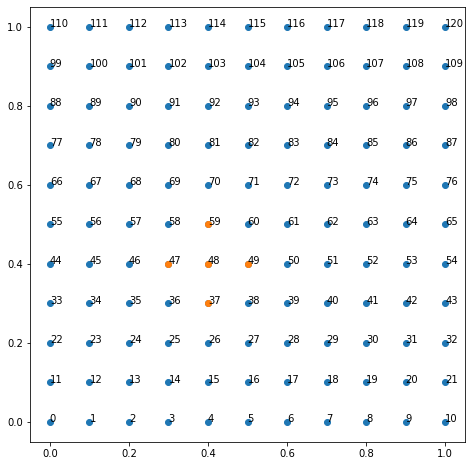

In [8]:
if n == 10:
    plt.figure(figsize=(8,8))
    plt.scatter(x,y)
    plt.scatter(pkt[:,0],pkt[:,1])
    k=0
    for p in pts:
        plt.text(*p,str(k))
        k+=1
    plt.gca().set_aspect(1)
    plt.show()

So folgt für den Punkt $(0.4,0.4)$ die Nummer 48 und die diskrete Gleichung lautet
$$-u_{37}-u_{47}+4\, u_{48}-u_{49}-u_{59} = f(x_{48}, y_{48})$$

In [9]:
stencil = np.array([4,-1,-1,-1,-1])
indstencil = np.array([0,-1,1,-n-1,n+1])

In [10]:
48+indstencil

array([48, 47, 49, 37, 59])

Wir führen nun einen Index mit allen Punkten ein:

In [11]:
ind = np.arange((n+1)**2)
ind

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120])

Die Randpunkt sind

In [12]:
indBND = [k for k in range(n+1)] # Randpunkte unten
indBND += [k for k in range(n*(n+1),(n+1)**2)] # Randpunkte oben
indBND += [k for k in range(n+1,n*(n+1),n+1)] # Randpunkte links
indBND += [k for k in range(2*(n+1)-1,(n+1)**2,n+1)] # Randpunkte rechts
indBND = np.array(indBND)
indBND

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120,  11,  22,  33,  44,
        55,  66,  77,  88,  99,  21,  32,  43,  54,  65,  76,  87,  98,
       109, 120])

Für die inneren Punkte haben wir

In [13]:
indInt = list(set(ind) - set(indBND))
indInt = np.array(indInt)
indInt

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  45,  46,  47,  48,  49,  50,  51,  52,  53,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  78,  79,  80,  81,  82,  83,  84,  85,  86,  89,  90,
        91,  92,  93,  94,  95,  96,  97, 100, 101, 102, 103, 104, 105,
       106, 107, 108])

Die Anzahl **Freiheitsgrade** unseres Problems ist gegeben durch

In [14]:
indInt.shape[0]

81

Die Werte der Funktion $u$ ist für alle Randpunkte gegeben.

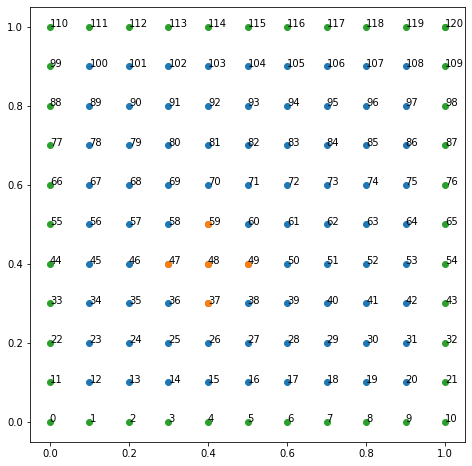

In [15]:
if n == 10:
    plt.figure(figsize=(8,8))
    plt.scatter(pts[indInt,0],pts[indInt,1])
    plt.scatter(pkt[:,0],pkt[:,1])
    plt.scatter(pts[indBND,0],pts[indBND,1])
    k=0
    for p in pts:
        plt.text(*p,str(k))
        k+=1
    plt.gca().set_aspect(1)
    plt.show()

Für alle inneren Punkte haben wir das Gleichungssystem 
$$-u_{i-n}-u_{i-1}+4\, u_{i}-u_{i+1}-u_{i+n} = h^2\, f(x_{i}, y_{i})\quad i \in \text{indInt}$$

Die Anzahl Zeilen der Systemmatrix wählen wir analog zu der Anzahl Gleichungen, während die Anzahl Spalten mit der Anzahl Punkte übereinstimmt:

In [16]:
A = np.zeros((indInt.shape[0],ind.shape[0]))

Wir berechnen nun die Matrix zum Gleichungssystem oben:

In [17]:
for i in range(A.shape[0]): # Daher über alle Zeilen
    A[i,indInt[i]+indstencil] += stencil # Stencil wird nur bei den inneren Freiheitsgrade dazu addiert. 

Diese Matrix beinhaltet alle Freiheitsgrade. Beschränken wir die Matrix auf die **inneren Freiheitsgrade** so erhalten wir folgendes Bild (Bandmatrix):

In [18]:
Aint = A[:,indInt]

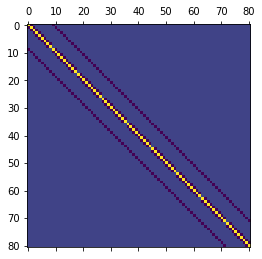

In [19]:
if n == 10:
    plt.matshow(Aint)

Nun soll das Gleichungssystem für alle internen Punkte extrahiert werden.
$$A_{\text{int}}\cdot u_{\text{int}} = b$$
Dazu wählen wir nur die Zeilen der inneren Freiheitsgrade und subtrahieren sämtliche Spalten der Freiheitsgrade des Rand von der Rechtenseite. 

Lösungsvektor für **alle** Freiheitsgrade, dh. Punkte

In [20]:
u = np.zeros_like(ind,dtype=float)

Funktion für die Randwerte

In [21]:
def g(x,y):
    return x*y#np.ones_like(x)

Initialisieren der Rand Freiheitsgrade

In [22]:
u[indBND] = g(pts[indBND,0],pts[indBND,1])

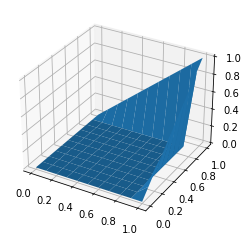

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,u.reshape((n+1),(n+1)))

Funktion der rechten Seite der Gleichung. Wir wählen 
$$f(x,y) = 1 \quad\forall (x,y)\in D$$

In [24]:
def f(x,y):
    #return np.sin(np.pi*x)*np.sin(np.pi*y)
    return -10*np.ones_like(x)

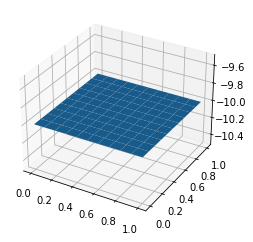

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,f(x,y))

Berechnen der rechten Seite

In [26]:
b = np.zeros_like(u[indInt])
b = h**2*f(pts[indInt,0],pts[indInt,0]) # f wird für die inneren Punkte berechnet
b -= A@u # im Vektor u sind nur Freiheitsgrade der Randpunkte nicht null (abhängig von g!).

In [27]:
cl = cho_factor(Aint)
u[indInt] = cho_solve(cl,b)

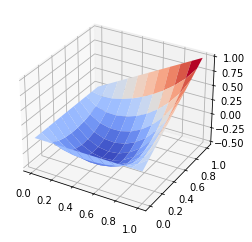

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,u.reshape((n+1),(n+1)),cmap=cm.coolwarm)

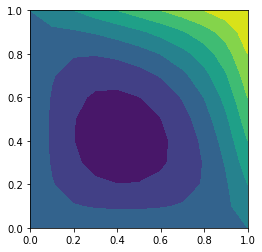

In [29]:
plt.contourf(x,y,u.reshape((n+1,n+1)))
plt.gca().set_aspect(1)
plt.show()

**Funktioniert nur mit NGSolve**

Vergleich mit Referenzlösung (FEM 4. Ordnung):

In [30]:
def FEMsolution(pts, n=100,order=4):
    from netgen.geom2d import unit_square
    from ngsolve import Mesh, H1, BilinearForm, LinearForm, GridFunction, grad, x, y, dx
    from ngsolve.webgui import Draw
    ngmesh = unit_square.GenerateMesh(maxh=1/n)
    mesh = Mesh(ngmesh)
    V = H1(mesh, order=order, dirichlet='bottom|right|top|left')
    u,v = V.TnT()
    a = BilinearForm(V)
    a += grad(u)*grad(v)*dx
    a.Assemble()
    b = LinearForm(V)
    b += -10*v*dx
    b.Assemble()
    gfu = GridFunction(V)
    gfu.Set(x*y, definedon=mesh.GetBoundaries())
    b.vec.data -= a.mat*gfu.vec
    gfu.vec.data += a.mat.Inverse(freedofs = V.FreeDofs())*b.vec
    Draw(gfu)
    return np.array([gfu(mesh(*p)) for p in pts])

In [31]:
np.linalg.norm(u-FEMsolution(pts,n=100))

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-67-g2f75ab1a8', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

0.034050659459700795

In [32]:
# 10, 0.034050659459700795
# 100, 0.0034719326551715442